In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [38]:
import torch
from torch import nn, optim
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("muted")
sns.set_style("whitegrid")

## 数据扩充

- 图片resize的采样方法
    - antialias 抗锯齿
    - bilinear  双线性
    - nearest 最近邻
    - bicubic

### resize

In [23]:
import PIL, random

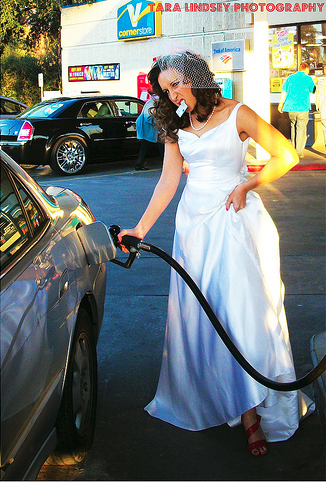

In [10]:
img = PIL.Image.open('./imgs/women.png')
img

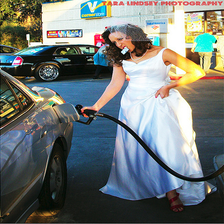

In [20]:
img.resize((224,224), resample=PIL.Image.ANTIALIAS)

### 翻转

In [28]:
def pil_random_flip(x, p=0.8):
    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<p else x

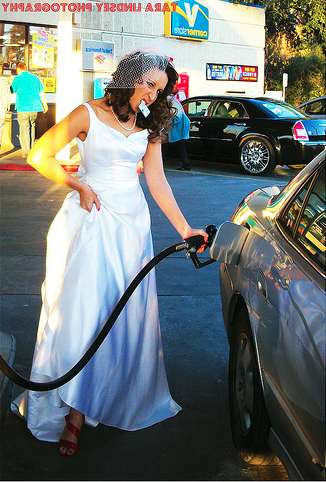

In [32]:
pil_random_flip(img)

- 写成 class 形式

In [35]:
class PilRandomFlip:
    _order=11
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random() < self.p else x

- 水平翻转，竖直翻转，90°翻转

In [43]:
PIL.Image.FLIP_LEFT_RIGHT,PIL.Image.ROTATE_90,PIL.Image.TRANSVERSE

(0, 2, 6)

(-0.5, 325.5, 481.5, -0.5)

(-0.5, 325.5, 481.5, -0.5)

(-0.5, 325.5, 481.5, -0.5)

(-0.5, 481.5, 325.5, -0.5)

(-0.5, 325.5, 481.5, -0.5)

(-0.5, 481.5, 325.5, -0.5)

(-0.5, 481.5, 325.5, -0.5)

(-0.5, 481.5, 325.5, -0.5)

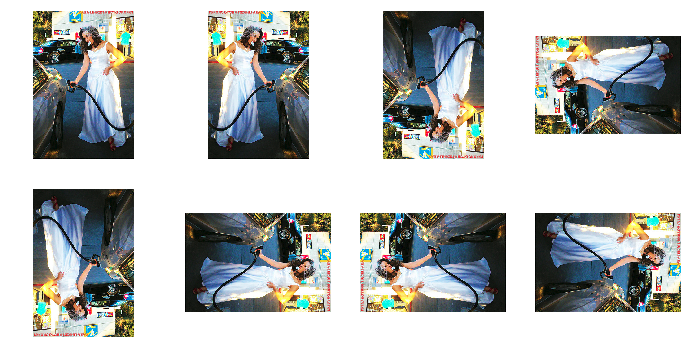

In [39]:
img1 = img.resize((224,224), resample=PIL.Image.NEAREST)
_, axs = plt.subplots(2, 4, figsize=(12, 6))
for i,ax in enumerate(axs.flatten()):
    if i==0: ax.imshow(img)
    else:    ax.imshow(img.transpose(i-1))
    ax.axis('off')

In [65]:
class PilTransform: _order=11

In [66]:
class PilRandomDihedral(PilTransform):
    def __init__(self, p=0.75): self.p=p*7/8 #Little hack to get the 1/8 identity dihedral transform taken into account.
    def __call__(self, x):
        if random.random()>self.p: return x
        return x.transpose(random.randint(0,6))

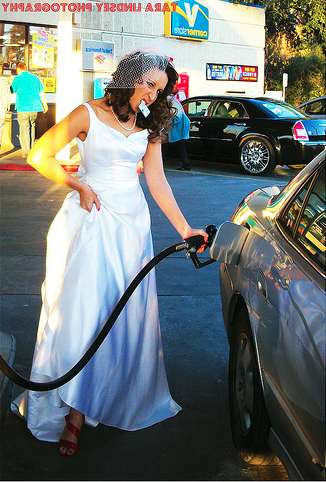

In [68]:
PilRandomDihedral()(img)

### 随机裁剪

要使用PIL裁剪图像，我们必须以这种格式指定顶部/左侧和底部/右角:(左，上，右，下）。 我们不会只裁剪我们想要的尺寸，而是首先裁剪我们想要的图像部分，然后调整大小。

In [69]:
img.size

(326, 482)

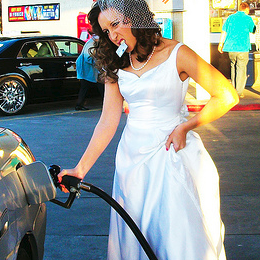

(260, 260)

In [70]:
img2 = img.crop((60,60,320,320))
img2
img2.size

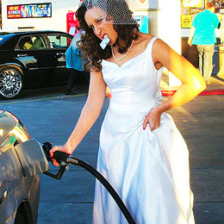

In [71]:
img2.resize((224,224), resample=PIL.Image.BILINEAR)

In [72]:
from random import randint

def process_sz(sz):
    sz = listify(sz)
    return tuple(sz if len(sz)==2 else [sz[0],sz[0]])

def default_crop_size(w,h): return [w,w] if w < h else [h,h]

class GeneralCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR): 
        self.resample,self.size = resample,process_sz(size)
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def default_crop_size(self, w,h): return default_crop_size(w,h)

    def __call__(self, x):
        csize = self.default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        return x.transform(self.size, PIL.Image.EXTENT, self.get_corners(*x.size, *csize), resample=self.resample)
    
    def get_corners(self, w, h): return (0,0,w,h)

class CenterCrop(GeneralCrop):
    def __init__(self, size, scale=1.14, resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale = scale
        
    def default_crop_size(self, w,h): return [w/self.scale,h/self.scale]
    
    def get_corners(self, w, h, wc, hc):
        return ((w-wc)//2, (h-hc)//2, (w-wc)//2+wc, (h-hc)//2+hc)

In [73]:
class RandomResizedCrop(GeneralCrop):
    def __init__(self, size, scale=(0.08,1.0), ratio=(3./4., 4./3.), resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale,self.ratio = scale,ratio
    
    def get_corners(self, w, h, wc, hc):
        area = w*h
        #Tries 10 times to get a proper crop inside the image.
        for attempt in range(10):
            area = random.uniform(*self.scale) * area
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            new_w = int(round(math.sqrt(area * ratio)))
            new_h = int(round(math.sqrt(area / ratio)))
            if new_w <= w and new_h <= h:
                left = random.randint(0, w - new_w)
                top  = random.randint(0, h - new_h)
                return (left, top, left + new_w, top + new_h)
        
        # Fallback to central crop
        left,top = randint(0,w-self.crop_size[0]),randint(0,h-self.crop_size[1])
        return (left, top, left+self.crop_size[0], top+self.crop_size[1])
        # Fallback to central crop

### 透视

In [74]:
from torch import FloatTensor,LongTensor

def find_coeffs(orig_pts, targ_pts):
    matrix = []
    #The equations we'll need to solve.
    for p1, p2 in zip(targ_pts, orig_pts):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = FloatTensor(matrix)
    B = FloatTensor(orig_pts).view(8, 1)
    #The 8 scalars we seek are solution of AX = B
    return list(torch.solve(B,A)[0][:,0])

In [75]:
def warp(img, size, src_coords, resample=PIL.Image.BILINEAR):
    w,h = size
    targ_coords = ((0,0),(0,h),(w,h),(w,0))
    c = find_coeffs(src_coords,targ_coords)
    res = img.transform(size, PIL.Image.PERSPECTIVE, list(c), resample=resample)
    return res

In [76]:
targ = ((0,0),(0,128),(128,128),(128,0))
src  = ((90,60),(30,280),(310,280),(250,60))

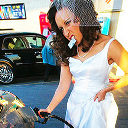

In [80]:
c = find_coeffs(src, targ)
img.transform((128,128), PIL.Image.PERSPECTIVE, list(c), resample=3)

torch.bmm 最快的矩阵乘法

In [81]:
torch.bmm??

Docstring:
bmm(batch1, batch2, out=None) -> Tensor

Performs a batch matrix-matrix product of matrices stored in :attr:`batch1`
and :attr:`batch2`.

:attr:`batch1` and :attr:`batch2` must be 3-D tensors each containing
the same number of matrices.

If :attr:`batch1` is a :math:`(b \times n \times m)` tensor, :attr:`batch2` is a
:math:`(b \times m \times p)` tensor, :attr:`out` will be a
:math:`(b \times n \times p)` tensor.

.. math::
    \text{out}_i = \text{batch1}_i \mathbin{@} \text{batch2}_i

.. note:: This function does not :ref:`broadcast <broadcasting-semantics>`.
          For broadcasting matrix products, see :func:`torch.matmul`.

Args:
    batch1 (Tensor): the first batch of matrices to be multiplied
    batch2 (Tensor): the second batch of matrices to be multiplied
    out (Tensor, optional): the output tensor

Example::

    >>> batch1 = torch.randn(10, 3, 4)
    >>> batch2 = torch.randn(10, 4, 5)
    >>> res = torch.bmm(batch1, batch2)
    >>> res.size()
    torch.Size([

## mixup

``` python
new_image = t * image1 + (1-t) * image2
```

where t is a float between 0 and 1. Then the target we assign to that image is the same combination of the original targets:

``` python
new_target = t * target1 + (1-t) * target2
```
pytorch loss
```python
loss(output, new_target) = t * loss(output, target1) + (1-t) * loss(output, target2)
```

## Label smoothing

Another regularization technique that's often used is label smoothing. It's designed to make the model a little bit less certain of it's decision by changing a little bit its target: instead of wanting to predict 1 for the correct class and 0 for all the others, we ask it to predict `1-ε` for the correct class and `ε` for all the others, with `ε` a (small) positive number and N the number of classes. This can be written as:

$$loss = (1-ε) ce(i) + ε \sum ce(j) / N$$

where `ce(x)` is cross-entropy of `x` (i.e. $-\log(p_{x})$), and `i` is the correct class. This can be coded in a loss function:

In [90]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction
    
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss/c, nll, self.ε)